In [1]:
# Install Keras
!pip install statsmodels

    100% |████████████████████████████████| 6.2MB 252kB/s eta 0:00:01
    100% |████████████████████████████████| 235kB 5.5MB/s eta 0:00:01


In [2]:
import tensorflow as tf
import pandas as pd
import math
import numpy
import random
import decimal
import scipy.linalg
import statsmodels.api as sm
from scipy import stats
import numpy as np
import numpy.random as nrand
import matplotlib.pyplot as plt
from sklearn import svm
import itertools
import sklearn
from sklearn.metrics import r2_score
%matplotlib inline

/usr/local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
import keras
from keras.models import Sequential, model_from_json, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D, Conv2D, Input
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.core import Reshape

Using TensorFlow backend.


In [4]:
class ModelParameters:
    """
    Encapsulates model parameters
    """
    
    def __init__(self,
                 all_time, all_delta, all_sigma, gbm_mu,
                 jumps_lamda=0.0, jumps_sigma=0.0, jumps_mu=0.0):
        
        # This is the amount of time to simulate for
        self.all_time = all_time
        
        # This is the delta, the rate of time e.g. 1/252 = daily, 1/12 = monthly
        self.all_delta = all_delta
        
        # This is the volatility of the stochastic processes
        # 0.001,1
        self.all_sigma = all_sigma
        
        # This is the annual drift factor for geometric brownian motion
        # -1,1
        self.gbm_mu = gbm_mu
        
        # This is the probability of a jump happening at each point in time
        #  0.0003,0.025
        self.lamda = jumps_lamda
        
        # This is the volatility of the jump size
        #   0.001, 1
        self.jumps_sigma = jumps_sigma
        
        # This is the average jump size
        # -0.1,0.1
        self.jumps_mu = jumps_mu
        

def random_model_params():
    
    return ModelParameters(
        # Fixed Parameters
        all_time=2000,
        all_delta=0.00396825396,
        
        # Random Parameters
        
        ### TODO: REDUCED SIGMA #######################
        all_sigma = nrand.uniform(0.001,0.2),
        ##############################################
        
        gbm_mu = nrand.uniform(-1,1),
        jumps_lamda=nrand.uniform(0.0001,0.025),
        jumps_sigma=nrand.uniform(0.001, 0.2),
        jumps_mu=nrand.uniform(-0.5,0.5),
    )

In [5]:
def plot_stochastic_processes(processes, title):
    """
    This method plots a list of stochastic processes with a specified title
    :return: plots the graph of the two
    """
    plt.style.use(['bmh'])
    fig, ax = plt.subplots(1)
    fig.suptitle(title, fontsize=16)
    ax.set_xlabel('Time, t')
    ax.set_ylabel('Simulated Asset Price')
    x_axis = numpy.arange(0, len(processes[0]), 1)
    for i in range(len(processes)):
        plt.plot(x_axis, processes[i])
    plt.show()

In [6]:
def brownian_motion_log_returns(param):
    """
    This method returns a Wiener process. The Wiener process is also called Brownian motion. For more information
    about the Wiener process check out the Wikipedia page: http://en.wikipedia.org/wiki/Wiener_process
    :param param: the model parameters object
    :return: brownian motion log returns
    """
    sqrt_delta_sigma = math.sqrt(param.all_delta) * param.all_sigma
    return nrand.normal(loc=0, scale=sqrt_delta_sigma, size=param.all_time)

def geometric_brownian_motion_log_returns(param):
    """
    This method constructs a sequence of log returns which, when exponentiated, produce a random Geometric Brownian
    Motion (GBM). GBM is the stochastic process underlying the Black Scholes options pricing formula.
    :param param: model parameters object
    :return: returns the log returns of a geometric brownian motion process
    """
    assert isinstance(param, ModelParameters)
    wiener_process = numpy.array(brownian_motion_log_returns(param))
    sigma_pow_mu_delta = (param.gbm_mu - 0.5 * math.pow(param.all_sigma, 2.0)) * param.all_delta
    return wiener_process + sigma_pow_mu_delta

def jump_diffusion_process(param):
    """
    This method produces a sequence of Jump Sizes which represent a jump diffusion process. These jumps are combined
    with a geometric brownian motion (log returns) to produce the Merton model.
    :param param: the model parameters object
    :return: jump sizes for each point in time (mostly zeroes if jumps are infrequent)
    """
    assert isinstance(param, ModelParameters)
    s_n = time = 0
    small_lamda = -(1.0 / param.lamda)
    jump_sizes = np.zeros(param.all_time)
    while s_n < param.all_time:
        s_n += small_lamda * math.log(random.uniform(0, 1))
        for j in range(0, param.all_time):
            if time * param.all_delta <= s_n * param.all_delta <= (j + 1) * param.all_delta:
                jump_sizes[j] += random.normalvariate(param.jumps_mu, param.jumps_sigma)
                break
        time += 1
    return jump_sizes

def geometric_brownian_motion_jump_diffusion_log_returns(param):
    """
    This method constructs combines a geometric brownian motion process (log returns) with a jump diffusion process
    (log returns) to produce a sequence of gbm jump returns.
    :param param: model parameters object
    :return: returns a GBM process with jumps in it
    """
    assert isinstance(param, ModelParameters)
    jump_diffusion = jump_diffusion_process(param)
    geometric_brownian_motion = geometric_brownian_motion_log_returns(param)
    return numpy.add(jump_diffusion, geometric_brownian_motion)

# Metrics

### R Squared

In [7]:
def r2(y_true, y_pred):
    SSE = K.sum(K.square(y_true-y_pred))
    SST = K.sum(K.square(y_true-K.mean(y_true)))
    return 1-SSE/SST

### Average absolute percentage error

In [8]:
def aape(y_true, y_pred):
    MSE = K.mean(K.abs((y_true-y_pred)/y_true))
    return 100*MSE

# Feedforward (using Moments & ACF)

In [41]:
feedforward = Sequential()
feedforward.add(Dense(2014, input_dim = 60, activation='elu'))
feedforward.add(Dense(1024, activation='elu'))
feedforward.add(Dense(512, activation='elu'))
feedforward.add(Dense(256, activation='elu'))
feedforward.add(Dense(128, activation='elu'))
feedforward.add(Dense(64, activation='elu'))
feedforward.add(Dense(32, activation='elu'))
feedforward.add(Dense(16, activation='elu'))
feedforward.add(Dense(5))

In [42]:
# Compile model
feedforward.compile(loss='mse', optimizer='adam', metrics=[r2])

I didn't normalise the training data. It took more than 60 epochs to train this network originally.

In [43]:
#feedforward.save("feedforward.h5")
feedforward = load_model("feedforward_running.h5")

OSError: Unable to open file (Unable to open file: name = 'feedforward_running.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [44]:
def batch_generator(all_time = 2000, paramset_size = 32, paths_p_paramset = 5):
    while True:
        RETURNS_ = []
        PARAMS_ = []
        
        for i in range(paramset_size):
            mp = random_model_params()
            mp.all_time = all_time
            
            for j in range(paths_p_paramset):
                PARAMS_.append(mp)
                RETURNS_.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))
        
        train_targets = np.array([[mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda] for mp in PARAMS_])
        
        train_moments = [np.append(stats.moment(example, moment = range(2,20)), np.mean(example)) for example in RETURNS_]

        train_statistics = np.array([np.append(train_moments[i], 
                              sm.tsa.stattools.acf(RETURNS_[i])) 
                    for i in range(len(RETURNS_))])

        yield train_statistics, train_targets

In [45]:
train_gen = batch_generator(paramset_size=10, paths_p_paramset=1)


In [47]:
histories = []

In [50]:
for i in range(150):
    print(str(i%9))
    history = feedforward.fit_generator(train_gen, steps_per_epoch = 50, epochs = 1)
    histories.append(history.history)
    feedforward.save("feedforward_running_gen.h5")

0
Epoch 1/1
50/50 [==============================] - 6s - loss: 0.0526 - r2: 0.3298     
1
Epoch 1/1
50/50 [==============================] - 6s - loss: 0.0557 - r2: 0.3405     
2
Epoch 1/1
50/50 [==============================] - 6s - loss: 0.0549 - r2: 0.3347     
3
Epoch 1/1
50/50 [==============================] - 6s - loss: 0.0584 - r2: 0.3042     
4
Epoch 1/1
19/50 [==========>...................] - ETA: 3s - loss: 0.0563 - r2: 0.2700

KeyboardInterrupt: 

# Feedforward 2

In [9]:
input_1 = Input(batch_shape = (None, 60))

layer1 = Dense(2048, activation='elu')(input_1)
layer2 = Dense(1024, activation='elu')(layer1)

layer3 = Dense(512, activation='elu')(layer2)
layer4 = Dense(256, activation='elu')(layer3)

layer5 = Dense(128, activation='elu')(layer4)
layer6 = Dense(64, activation='elu')(layer5)

layer7 = Dense(32, activation='elu')(layer5)
last_layer = Dense(16, activation='elu')(layer7)

output1 = Dense(1, name="sigma")(last_layer)
output2 = Dense(1, name="mu")(last_layer)
output3 = Dense(1, name="jump_sigma")(last_layer)
output4 = Dense(1, name="jump_mu")(last_layer)
output5 = Dense(1, name="lambda")(last_layer)

In [10]:
feedforward = Model(input = input_1, output=[output1, output2, output3, output4, output5])

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  """Entry point for launching an IPython kernel.


In [11]:
# Compile model
feedforward.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2, 'mean_absolute_percentage_error'])

In [12]:
feedforward_CallBack = keras.callbacks.TensorBoard(log_dir='./feedforward', histogram_freq=0, write_graph=True, write_images=True)

In [13]:
def batch_generator(all_time = 2000, paramset_size = 32, paths_p_paramset = 5):
    while True:
        RETURNS_ = []
        PARAMS_ = []
        
        for i in range(paramset_size):
            mp = random_model_params()
            mp.all_time = all_time
            
            for j in range(paths_p_paramset):
                PARAMS_.append(mp)
                RETURNS_.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))
        
        train_moments = [np.append(stats.moment(example, moment = range(2,20)), np.mean(example)) for example in RETURNS_]

        train_statistics = np.array([np.append(train_moments[i], 
                              sm.tsa.stattools.acf(RETURNS_[i])) 
                    for i in range(len(RETURNS_))])
        
        sigmas = np.array([[mp.all_sigma] for mp in PARAMS_])
        mus = np.array([[mp.gbm_mu] for mp in PARAMS_])
        jump_sigmas = np.array([[mp.jumps_sigma] for mp in PARAMS_])
        jump_mus = np.array([[mp.jumps_mu] for mp in PARAMS_])
        lambdas = np.array([[mp.lamda] for mp in PARAMS_])
        
        yield train_statistics, [sigmas, mus, jump_sigmas, jump_mus, lambdas]

train_gen = batch_generator(paramset_size=750, paths_p_paramset=1)

In [14]:
feedforward.load_weights("feedforward_running_gen_2.h5")

In [15]:
#mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda
mp = ModelParameters(
        # Fixed Parameters
        all_time=2000,
        all_delta=0.00396825396,
        
        # Random Parameters
        
        ### TODO: REDUCED SIGMA #######################
        all_sigma = 0.1,
        ##############################################
        
        gbm_mu = 0.05,
        jumps_sigma=0.07,
        jumps_mu=0.05,
        jumps_lamda=0.02,
    )
test_set = []
for i in range(1000):
    if (i%100 == 0):
        print(i)
    test_set.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))

0
100
200
300
400
500
600
700
800
900


In [16]:
train_moments = [np.append(stats.moment(example, moment = range(2,20)), np.mean(example)) for example in test_set]

train_statistics2 = np.array([np.append(train_moments[i], 
                              sm.tsa.stattools.acf(test_set[i])) 
                    for i in range(len(test_set))])

In [ ]:
histories2 = np.load("feedforward_mo_histories.npy").tolist()
ff_predicts = np.load("ff_predicts.npy").tolist()
#histories2 = []
#ff_predicts = []

In [ ]:
for i in range(1000):
    history = feedforward.fit_generator(train_gen, steps_per_epoch = 5, epochs = 1)
    histories2.append(history.history)
    ff_predicts.append(feedforward.predict(train_statistics2))
    feedforward.save_weights("feedforward_running_gen_2.h5")
    
    np.save("feedforward_mo_histories.npy", histories2)
    np.save("ff_predicts.npy", ff_predicts)
    
    !git add --all
    !git commit -am "updated history, predictions and model"
    !git push -u origin master

Epoch 1/1
5/5 [==============================] - 45s - loss: 0.2402 - sigma_loss: 0.0051 - mu_loss: 0.1662 - jump_sigma_loss: 0.0068 - jump_mu_loss: 0.0574 - lambda_loss: 0.0048 - sigma_r2: -0.4974 - sigma_mean_absolute_percentage_error: 215.4744 - mu_r2: 0.5058 - mu_mean_absolute_percentage_error: 449.4896 - jump_sigma_r2: -1.0620 - jump_sigma_mean_absolute_percentage_error: 228.1421 - jump_mu_r2: 0.2984 - jump_mu_mean_absolute_percentage_error: 383.7338 - lambda_r2: -90.4068 - lambda_mean_absolute_percentage_error: 1418.2112    
[master 219d800] updated history, predictions and model
 6 files changed, 70 insertions(+)
 create mode 100644 .ipynb_checkpoints/Untitled3-checkpoint.ipynb
 create mode 100644 Untitled3.ipynb
 create mode 100644 command.sh
 rewrite feedforward_mo_histories.npy (93%)
Counting objects: 8, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (8/8), done.
Writing objects: 100% (8/8), 10.40 MiB | 8.55 MiB/s, done.
Total 8 (delta 4), reused 0 (

5/5 [==============================] - 44s - loss: 0.0474 - sigma_loss: 0.0033 - mu_loss: 0.0288 - jump_sigma_loss: 0.0035 - jump_mu_loss: 0.0114 - lambda_loss: 3.6506e-04 - sigma_r2: -0.0178 - sigma_mean_absolute_percentage_error: 211.2720 - mu_r2: 0.9146 - mu_mean_absolute_percentage_error: 109.0445 - jump_sigma_r2: -0.0699 - jump_sigma_mean_absolute_percentage_error: 174.1441 - jump_mu_r2: 0.8643 - jump_mu_mean_absolute_percentage_error: 97.3711 - lambda_r2: -6.1172 - lambda_mean_absolute_percentage_error: 283.6939    
[master 1200918] updated history, predictions and model
 3 files changed, 0 insertions(+), 0 deletions(-)
Counting objects: 5, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 10.35 MiB | 10.03 MiB/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://RWMostert:N0ne of that.@github.com/RWMostert/Merton-Jump-Diffusion-Calibration-T

In [156]:
np.save("feedforward_mo_histories.npy", histories2)

In [19]:
sigma_mean_absolute_percentage_error = []
lambda_mean_absolute_percentage_error = []
jump_sigma_mean_absolute_percentage_error = []
jump_mu_mean_absolute_percentage_error = []
mu_mean_absolute_percentage_error = []

sigma_r2 = []
lambda_r2 = []
jump_sigma_r2 = []
mu_r2 = []
jump_mu_r2 = []

jump_mu_loss = []
lambda_loss = []
sigma_loss = []
mu_loss = []
jump_sigma_loss = []

loss = []

for history in histories2:
    sigma_mean_absolute_percentage_error.append(history['sigma_mean_absolute_percentage_error'])
    lambda_mean_absolute_percentage_error.append(history['lambda_mean_absolute_percentage_error'])
    jump_sigma_mean_absolute_percentage_error.append(history['jump_sigma_mean_absolute_percentage_error'])
    jump_mu_mean_absolute_percentage_error.append(history['jump_mu_mean_absolute_percentage_error'])
    mu_mean_absolute_percentage_error.append(history['mu_mean_absolute_percentage_error'])
    
    sigma_r2.append(history['sigma_r2'])
    lambda_r2.append(history['lambda_r2'])
    jump_sigma_r2.append(history['jump_sigma_r2'])
    mu_r2.append(history['mu_r2'])
    jump_mu_r2.append(history['jump_mu_r2'])
    
    jump_mu_loss.append(history['jump_mu_loss'])
    lambda_loss.append(history['lambda_loss'])
    sigma_loss.append(history['sigma_loss'])
    mu_loss.append(history['mu_loss'])
    jump_sigma_loss.append(history['jump_sigma_loss'])
    
    loss.append(history['loss'])

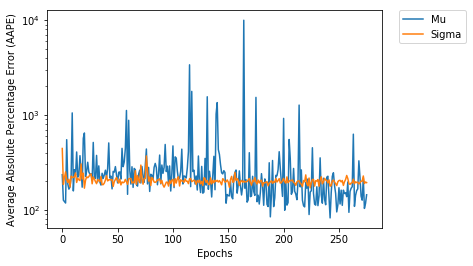

In [20]:
plt.plot(mu_mean_absolute_percentage_error, label="Mu")
plt.plot(sigma_mean_absolute_percentage_error, label="Sigma")
plt.ylabel("Average Absolute Percentage Error (AAPE)")
plt.xlabel("Epochs")
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

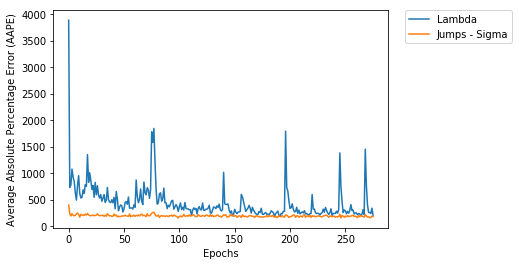

In [21]:
plt.plot(lambda_mean_absolute_percentage_error, label="Lambda")
plt.plot(jump_sigma_mean_absolute_percentage_error, label="Jumps - Sigma")

plt.ylabel("Average Absolute Percentage Error (AAPE)")
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

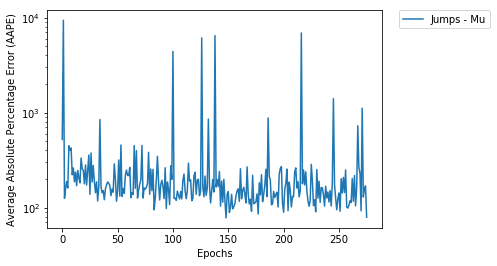

In [22]:
plt.plot(jump_mu_mean_absolute_percentage_error, label="Jumps - Mu")

plt.ylabel("Average Absolute Percentage Error (AAPE)")
plt.xlabel("Epochs")
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

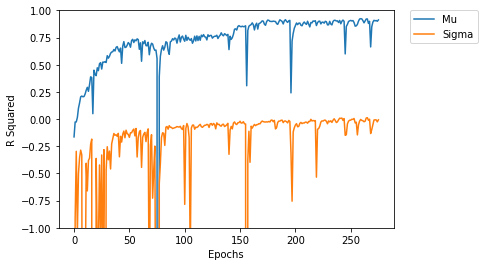

In [23]:
plt.figure()
plt.plot(mu_r2, label="Mu")
plt.plot(sigma_r2, label="Sigma")
plt.ylabel("R Squared")
plt.xlabel("Epochs")
plt.ylim([-1, 1])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

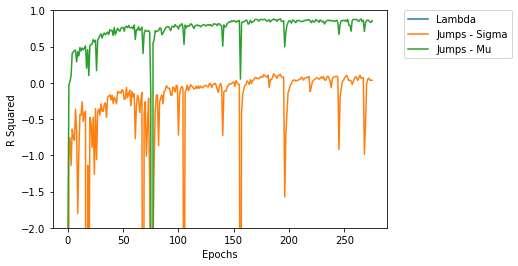

In [24]:
plt.figure()
plt.plot(lambda_r2, label="Lambda")
plt.plot(jump_sigma_r2, label="Jumps - Sigma")
plt.plot(jump_mu_r2, label="Jumps - Mu")
plt.ylabel("R Squared")
plt.xlabel("Epochs")
plt.ylim([-2, 1])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

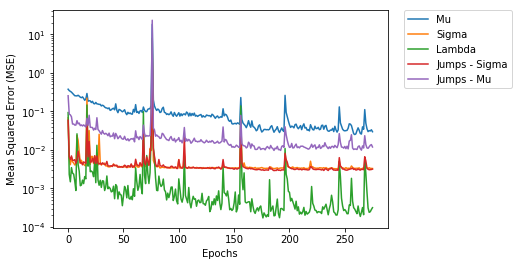

In [25]:
plt.plot(mu_loss, label="Mu")
plt.plot(sigma_loss, label="Sigma")
plt.plot(lambda_loss, label="Lambda")
plt.plot(jump_sigma_loss, label="Jumps - Sigma")
plt.plot(jump_mu_loss, label="Jumps - Mu")
plt.ylabel("Mean Squared Error (MSE)")
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.yscale('log')
plt.show()

# Feedforward  RELU

In [8]:
input_1 = Input(batch_shape = (None, 60))

layer1 = Dense(2048, activation='relu')(input_1)
layer2 = Dense(1024, activation='relu')(layer1)

layer3 = Dense(512, activation='relu')(layer2)
layer4 = Dense(256, activation='relu')(layer3)

layer5 = Dense(128, activation='relu')(layer4)
layer6 = Dense(64, activation='relu')(layer5)

layer7 = Dense(32, activation='relu')(layer5)
last_layer = Dense(16, activation='relu')(layer7)

output1 = Dense(1, name="sigma")(last_layer)
output2 = Dense(1, name="mu")(last_layer)
output3 = Dense(1, name="jump_sigma")(last_layer)
output4 = Dense(1, name="jump_mu")(last_layer)
output5 = Dense(1, name="lambda")(last_layer)

In [9]:
feedforward = Model(input = input_1, output=[output1, output2, output3, output4, output5])

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  """Entry point for launching an IPython kernel.


In [10]:
# Compile model
feedforward.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2, 'mean_absolute_percentage_error'])

In [11]:
feedforward_CallBack = keras.callbacks.TensorBoard(log_dir='./feedforward', histogram_freq=0, write_graph=True, write_images=True)

In [12]:
def batch_generator(all_time = 2000, paramset_size = 32, paths_p_paramset = 5):
    while True:
        RETURNS_ = []
        PARAMS_ = []
        
        for i in range(paramset_size):
            mp = random_model_params()
            mp.all_time = all_time
            
            for j in range(paths_p_paramset):
                PARAMS_.append(mp)
                RETURNS_.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))
        
        train_moments = [np.append(stats.moment(example, moment = range(2,20)), np.mean(example)) for example in RETURNS_]

        train_statistics = np.array([np.append(train_moments[i], 
                              sm.tsa.stattools.acf(RETURNS_[i])) 
                    for i in range(len(RETURNS_))])
        
        sigmas = np.array([[mp.all_sigma] for mp in PARAMS_])
        mus = np.array([[mp.gbm_mu] for mp in PARAMS_])
        jump_sigmas = np.array([[mp.jumps_sigma] for mp in PARAMS_])
        jump_mus = np.array([[mp.jumps_mu] for mp in PARAMS_])
        lambdas = np.array([[mp.lamda] for mp in PARAMS_])
        
        yield train_statistics, [sigmas, mus, jump_sigmas, jump_mus, lambdas]

train_gen = batch_generator(paramset_size=250, paths_p_paramset=1)

In [13]:
feedforward.load_weights("feedforward_running_gen_2_relu.h5")

In [14]:
#mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda
mp = ModelParameters(
        # Fixed Parameters
        all_time=2000,
        all_delta=0.00396825396,
        
        # Random Parameters
        
        ### TODO: REDUCED SIGMA #######################
        all_sigma = 0.1,
        ##############################################
        
        gbm_mu = 0.05,
        jumps_sigma=0.07,
        jumps_mu=0.05,
        jumps_lamda=0.02,
    )
test_set = []
for i in range(1000):
    if (i%100 == 0):
        print(i)
    test_set.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))

0
100
200
300
400
500
600
700
800
900


In [15]:
train_moments = [np.append(stats.moment(example, moment = range(2,20)), np.mean(example)) for example in test_set]

train_statistics2 = np.array([np.append(train_moments[i], 
                              sm.tsa.stattools.acf(test_set[i])) 
                    for i in range(len(test_set))])

In [ ]:
histories2_relu = np.load("feedforward_mo_histories_relu.npy").tolist()
ff_predicts_relu = np.load("ff_predicts_relu.npy").tolist()
#histories2_relu = []
#ff_predicts_relu = []

In [ ]:
for i in range(1000):
    history = feedforward.fit_generator(train_gen, steps_per_epoch = 50, epochs = 1)
    histories2_relu.append(history.history)
    ff_predicts_relu.append(feedforward.predict(train_statistics2))
    feedforward.save_weights("feedforward_running_gen_2_relu.h5")
    
    np.save("feedforward_mo_histories_relu.npy", histories2_relu)
    np.save("ff_predicts_relu.npy", ff_predicts_relu)
    
    !git add --all
    !git commit -am "updated history, predictions and model"
    #!git remote add origin https://RWMostert:N0ne\ of\ that.@github.com/RWMostert/Merton-Jump-Diffusion-Calibration-Tests.git
    !git push -u origin master

Epoch 1/1
50/50 [==============================] - 150s - loss: 0.0818 - sigma_loss: 0.0033 - mu_loss: 0.0574 - jump_sigma_loss: 0.0032 - jump_mu_loss: 0.0178 - lambda_loss: 1.1165e-04 - sigma_r2: -0.0200 - sigma_mean_absolute_percentage_error: 185.6119 - mu_r2: 0.8263 - mu_mean_absolute_percentage_error: 178.4586 - jump_sigma_r2: 0.0198 - jump_sigma_mean_absolute_percentage_error: 186.9658 - jump_mu_r2: 0.7857 - jump_mu_mean_absolute_percentage_error: 273.3667 - lambda_r2: -1.1934 - lambda_mean_absolute_percentage_error: 198.8911   
[master 3b8205e] updated history, predictions and model
 7 files changed, 94 insertions(+), 175 deletions(-)
 create mode 100644 .ipynb_checkpoints/Untitledl-checkpoint.ipynb
 create mode 100644 Untitledl.ipynb
 create mode 100644 command.sh
 rewrite feedforward_mo_histories_relu.npy (94%)
Counting objects: 9, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (9/9), done.
Writing objects: 100% (9/9), 811.99 KiB | 0 bytes/s, done.
Tot

50/50 [==============================] - 147s - loss: 0.0357 - sigma_loss: 0.0031 - mu_loss: 0.0203 - jump_sigma_loss: 0.0028 - jump_mu_loss: 0.0094 - lambda_loss: 3.9940e-05 - sigma_r2: 0.0429 - sigma_mean_absolute_percentage_error: 184.8669 - mu_r2: 0.9384 - mu_mean_absolute_percentage_error: 255.2699 - jump_sigma_r2: 0.1620 - jump_sigma_mean_absolute_percentage_error: 182.3789 - jump_mu_r2: 0.8860 - jump_mu_mean_absolute_percentage_error: 130.0641 - lambda_r2: 0.2219 - lambda_mean_absolute_percentage_error: 110.2740   
[master 2c713b2] updated history, predictions and model
 3 files changed, 0 insertions(+), 0 deletions(-)
Counting objects: 5, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 834.73 KiB | 0 bytes/s, done.
Total 5 (delta 4), reused 0 (delta 0)
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To https://RWMostert:N0ne of that.@github.com/RWMostert/Merton-Jump-Diffusion-Calibration-Te

In [156]:
np.save("feedforward_mo_histories.npy", histories2)

In [157]:
sigma_mean_absolute_percentage_error = []
lambda_mean_absolute_percentage_error = []
jump_sigma_mean_absolute_percentage_error = []
jump_mu_mean_absolute_percentage_error = []
mu_mean_absolute_percentage_error = []

sigma_r2 = []
lambda_r2 = []
jump_sigma_r2 = []
mu_r2 = []
jump_mu_r2 = []

jump_mu_loss = []
lambda_loss = []
sigma_loss = []
mu_loss = []
jump_sigma_loss = []

loss = []

for history in histories2:
    sigma_mean_absolute_percentage_error.append(history['sigma_mean_absolute_percentage_error'])
    lambda_mean_absolute_percentage_error.append(history['lambda_mean_absolute_percentage_error'])
    jump_sigma_mean_absolute_percentage_error.append(history['jump_sigma_mean_absolute_percentage_error'])
    jump_mu_mean_absolute_percentage_error.append(history['jump_mu_mean_absolute_percentage_error'])
    mu_mean_absolute_percentage_error.append(history['mu_mean_absolute_percentage_error'])
    
    sigma_r2.append(history['sigma_r2'])
    lambda_r2.append(history['lambda_r2'])
    jump_sigma_r2.append(history['jump_sigma_r2'])
    mu_r2.append(history['mu_r2'])
    jump_mu_r2.append(history['jump_mu_r2'])
    
    jump_mu_loss.append(history['jump_mu_loss'])
    lambda_loss.append(history['lambda_loss'])
    sigma_loss.append(history['sigma_loss'])
    mu_loss.append(history['mu_loss'])
    jump_sigma_loss.append(history['jump_sigma_loss'])
    
    loss.append(history['loss'])

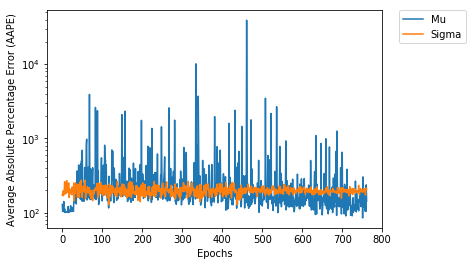

In [158]:
plt.plot(mu_mean_absolute_percentage_error, label="Mu")
plt.plot(sigma_mean_absolute_percentage_error, label="Sigma")
plt.ylabel("Average Absolute Percentage Error (AAPE)")
plt.xlabel("Epochs")
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

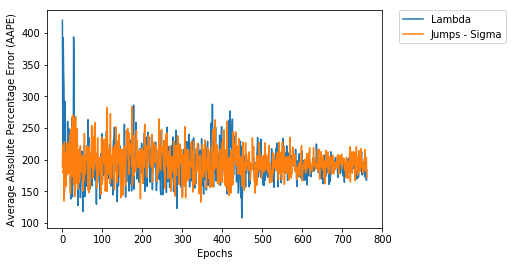

In [159]:
plt.plot(lambda_mean_absolute_percentage_error, label="Lambda")
plt.plot(jump_sigma_mean_absolute_percentage_error, label="Jumps - Sigma")

plt.ylabel("Average Absolute Percentage Error (AAPE)")
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

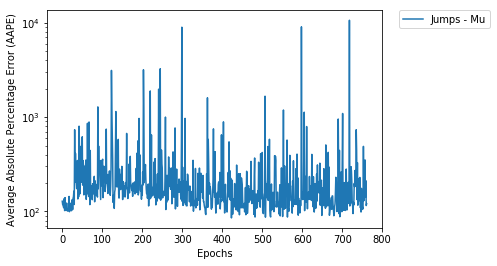

In [160]:
plt.plot(jump_mu_mean_absolute_percentage_error, label="Jumps - Mu")

plt.ylabel("Average Absolute Percentage Error (AAPE)")
plt.xlabel("Epochs")
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

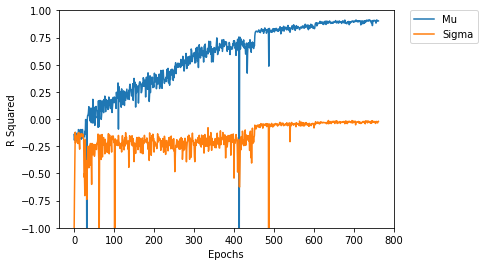

In [161]:
plt.figure()
plt.plot(mu_r2, label="Mu")
plt.plot(sigma_r2, label="Sigma")
plt.ylabel("R Squared")
plt.xlabel("Epochs")
plt.ylim([-1, 1])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

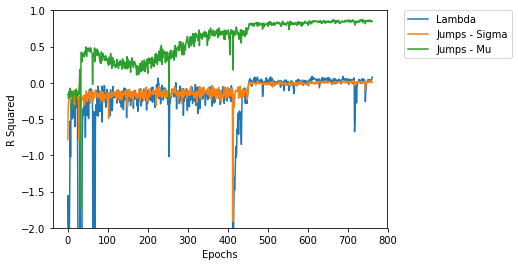

In [162]:
plt.figure()
plt.plot(lambda_r2, label="Lambda")
plt.plot(jump_sigma_r2, label="Jumps - Sigma")
plt.plot(jump_mu_r2, label="Jumps - Mu")
plt.ylabel("R Squared")
plt.xlabel("Epochs")
plt.ylim([-2, 1])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

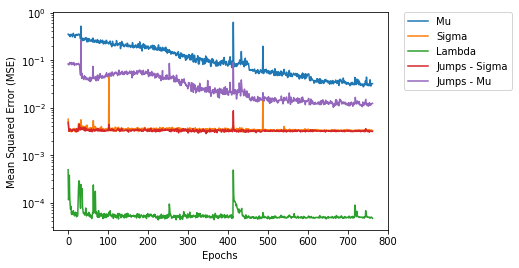

In [163]:
plt.plot(mu_loss, label="Mu")
plt.plot(sigma_loss, label="Sigma")
plt.plot(lambda_loss, label="Lambda")
plt.plot(jump_sigma_loss, label="Jumps - Sigma")
plt.plot(jump_mu_loss, label="Jumps - Mu")
plt.ylabel("Mean Squared Error (MSE)")
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.yscale('log')
plt.show()

# Feedforward Single Paramter - MU

In [113]:
input_1 = Input(batch_shape = (None, 60))

layer1 = Dense(2048, activation='relu')(input_1)
layer2 = Dense(1024, activation='relu')(layer1)

dropout1 = Dropout(0.2)(layer2)

layer3 = Dense(512, activation='relu')(dropout1)
layer4 = Dense(256, activation='relu')(layer3)

dropout2 = Dropout(0.2)(layer4)

layer5 = Dense(128, activation='relu')(dropout2)
layer6 = Dense(64, activation='relu')(layer5)

dropout3 = Dropout(0.2)(layer6)

layer7 = Dense(32, activation='relu')(dropout3)
last_layer = Dense(16, activation='relu')(layer7)

output2 = Dense(1, name="mu")(last_layer)

feedforward_mu = Model(input = input_1, output=[output2])
# Compile model
feedforward_mu.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2, 'mean_absolute_percentage_error'])

feedforward_mu_CallBack = keras.callbacks.TensorBoard(log_dir='./feedforward_mu', histogram_freq=0, write_graph=True, write_images=True)


/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


In [120]:
def batch_generator(all_time = 2000, paramset_size = 32, paths_p_paramset = 5):
    while True:
        RETURNS_ = []
        PARAMS_ = []
        
        for i in range(paramset_size):
            mp = random_model_params()
            mp.all_time = all_time
            
            for j in range(paths_p_paramset):
                PARAMS_.append(mp)
                RETURNS_.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))
        
        train_moments = [np.append(stats.moment(example, moment = range(2,20)), np.mean(example)) for example in RETURNS_]

        train_statistics = np.array([np.append(train_moments[i], 
                              sm.tsa.stattools.acf(RETURNS_[i])) 
                    for i in range(len(RETURNS_))])
        
        mus = np.array([[mp.gbm_mu] for mp in PARAMS_])
        
        yield train_statistics, [mus]

train_gen = batch_generator(paramset_size=10, paths_p_paramset=1)

In [118]:
histories_mu = []

In [121]:
for i in range(1000):
    history = feedforward_mu.fit_generator(train_gen, steps_per_epoch = 250, epochs = 1)
    histories_mu.append(history.history)
    feedforward_mu.save_weights("feedforward_mu.h5")

Epoch 1/1
250/250 [==============================] - 30s - loss: 0.3351 - r2: -0.1198 - mean_absolute_percentage_error: 118.2604    
Epoch 1/1
250/250 [==============================] - 30s - loss: 0.3354 - r2: -0.2125 - mean_absolute_percentage_error: 105.5254    
Epoch 1/1
250/250 [==============================] - 31s - loss: 0.3371 - r2: -0.1570 - mean_absolute_percentage_error: 105.2617    
Epoch 1/1
250/250 [==============================] - 30s - loss: 0.3381 - r2: -0.1641 - mean_absolute_percentage_error: 106.5378    
Epoch 1/1
250/250 [==============================] - 31s - loss: 0.3303 - r2: -0.1283 - mean_absolute_percentage_error: 112.9082    
Epoch 1/1
250/250 [==============================] - 30s - loss: 0.3319 - r2: -0.1316 - mean_absolute_percentage_error: 107.2835     ETA: 0s - loss: 0.3327 - r2: -0.1321 - mean_absolute_percentage_error
Epoch 1/1
250/250 [==============================] - 30s - loss: 0.3329 - r2: -0.1331 - mean_absolute_percentage_error: 112.5001    

KeyboardInterrupt: 

# Feedforward with ReLu's

In [59]:
feedforward = Sequential()
feedforward.add(Dense(4096, input_dim = 60, activation='relu'))
feedforward.add(Dense(1024, activation='relu'))
feedforward.add(Dense(256, activation='relu'))
feedforward.add(Dense(5))

In [60]:
# Compile model
feedforward.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=[r2])

In [61]:
for i in range(150):
    print(str(i%9))
    train_statistics = np.load("FF_Statistics_"+str(i%9)+".npy")
    train_targets = np.load("FF_Targets_"+str(i%9)+".npy")
    
    feedforward.fit(np.array(train_statistics[:80000]), np.array(train_targets[:80000]), nb_epoch=1, batch_size=100, validation_data=(train_statistics[80000:], train_targets[80000:]))
    feedforward.save_weights("feedforward_running_weights.h5")

0
Train on 80000 samples, validate on 20000 samples
Epoch 1/1
80000/80000 [==============================] - 13s - loss: 9505966.6943 - r2: -885683585150.6067 - val_loss: 5439914.2673 - val_r2: -960474192033.1541
1
Train on 80000 samples, validate on 20000 samples
Epoch 1/1
80000/80000 [==============================] - 13s - loss: 14306311.1634 - r2: -2248202695329.9482 - val_loss: 688596.2476 - val_r2: -849288935.4370
2
Train on 80000 samples, validate on 20000 samples
Epoch 1/1
80000/80000 [==============================] - 13s - loss: 270136.1424 - r2: -3779888320.1694 - val_loss: 91.8446 - val_r2: -0.0777
3
Train on 80000 samples, validate on 20000 samples
Epoch 1/1
80000/80000 [==============================] - 13s - loss: 101.8298 - r2: -0.1094 - val_loss: 46244.4008 - val_r2: -10094375.7593
4
Train on 80000 samples, validate on 20000 samples
Epoch 1/1
80000/80000 [==============================] - 13s - loss: 14523.6408 - r2: -5899982.5200 - val_loss: 93.2509 - val_r2: -0.0701


KeyboardInterrupt: 

# Feedforward with eLu's

In [62]:
feedforward = Sequential()
feedforward.add(Dense(2014, input_dim = 60, activation='tanh'))
feedforward.add(Dense(1024, activation='tanh'))
feedforward.add(Dense(512, activation='tanh'))
feedforward.add(Dense(256, activation='tanh'))
feedforward.add(Dense(128, activation='tanh'))
feedforward.add(Dense(64, activation='tanh'))
feedforward.add(Dense(32, activation='tanh'))
feedforward.add(Dense(16, activation='tanh'))
feedforward.add(Dense(5))

In [63]:
# Compile model
feedforward.compile(loss="mean_squared_error", optimizer='adam', metrics=[r2])

In [64]:
for i in range(150):
    print(str(i%8))
    train_statistics = np.load("FF_Statistics_"+str(i%8)+".npy")
    train_targets = np.load("FF_Targets_"+str(i%8)+".npy")
    
    feedforward.fit(np.array(train_statistics[:80000]), np.array(train_targets[:80000]), nb_epoch=1, batch_size=100, validation_data=(train_statistics[80000:], train_targets[80000:]))
    feedforward.save_weights("feedforward_running_weights_elu_mape.h5")

0
Train on 80000 samples, validate on 20000 samples
Epoch 1/1
80000/80000 [==============================] - 11s - loss: 0.0624 - r2: 0.4875 - val_loss: 0.0336 - val_r2: 0.7227
1
Train on 80000 samples, validate on 20000 samples
Epoch 1/1
80000/80000 [==============================] - 11s - loss: 0.0315 - r2: 0.7392 - val_loss: 0.0318 - val_r2: 0.7361
2
Train on 80000 samples, validate on 20000 samples
Epoch 1/1
80000/80000 [==============================] - 11s - loss: 0.0305 - r2: 0.7492 - val_loss: 0.0299 - val_r2: 0.7508
3
Train on 80000 samples, validate on 20000 samples
Epoch 1/1
80000/80000 [==============================] - 11s - loss: 0.0288 - r2: 0.7639 - val_loss: 0.0285 - val_r2: 0.7670
4
Train on 80000 samples, validate on 20000 samples
Epoch 1/1
80000/80000 [==============================] - 11s - loss: 0.0283 - r2: 0.7667 - val_loss: 0.0308 - val_r2: 0.7481
5
Train on 80000 samples, validate on 20000 samples
Epoch 1/1
80000/80000 [==============================] - 11s - 

KeyboardInterrupt: 

# 2D Convolutional Neural Network

In [8]:
covnet = Sequential()
covnet.add(Convolution2D(40, 3, 3, input_shape=(40, 50, 1), border_mode='same', activation='tanh'))
covnet.add(Convolution2D(40, 3, 3, activation='tanh', border_mode='same'))
covnet.add(MaxPooling2D(pool_size=(2,2)))

covnet.add(Convolution2D(64, 3, 3, border_mode='same', activation='tanh'))
covnet.add(Convolution2D(64, 3, 3, activation='tanh', border_mode='same'))
covnet.add(MaxPooling2D(pool_size=(2,2)))

covnet.add(Convolution2D(128, 3, 3, border_mode='same', activation='tanh'))
covnet.add(Convolution2D(128, 3, 3, activation='tanh', border_mode='same'))
covnet.add(MaxPooling2D(pool_size=(2,2)))

covnet.add(Flatten())
covnet.add(Dense(1024, activation='tanh'))
covnet.add(Dense(512, activation='tanh'))
covnet.add(Dense(5))

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(40, (3, 3), activation="tanh", input_shape=(40, 50, 1..., padding="same")`
  
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(40, (3, 3), activation="tanh", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="tanh", padding="same")`
  
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="tanh", padding="same")`
  import sys
/home/carnd/anaconda3/envs/carnd-term1/lib/p

In [10]:
covnet.compile('adam', 'mean_squared_error', metrics=[r2, "mean_absolute_percentage_error"])
#covnet.load_weights("covnet_mape_running.h5")
covnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 40, 50, 40)        400       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 50, 40)        14440     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 25, 40)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 25, 64)        23104     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 25, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 12, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 12, 128)       73856     
__________

In [ ]:
covnet.load_weights("covnet_mse_tanh_running.h5")

In [ ]:
covnet.save("covnet_y.h5")

In [ ]:
#RETURNS_, PARAMS_ = get_returns(2000)
RETURNS_ = np.load("MertonReturns_2000_0.npy")
PARAMS_ = np.load("ModelParameters_2000_0.npy")
train_data = np.reshape(np.array(RETURNS_), (100000, 40, 50, 1))
train_targets = np.array([[mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda] for mp in PARAMS_])

In [ ]:
random_permute = np.random.permutation(len(train_data))
train_data = train_data[random_permute]
train_targets = train_targets[random_permute]

In [49]:
for i in range(150):
    RETURNS_ = np.load("MertonReturns_2000_"+str(7-i%8)+".npy")
    PARAMS_ = np.load("ModelParameters_2000_"+str(7-i%8)+".npy")
    train_data = np.reshape(np.array(RETURNS_), (100000, 40, 50, 1))
    train_targets = np.array([[mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda] for mp in PARAMS_])

    history = covnet.fit(np.array(train_data[:80000]), np.array(train_targets[:80000]), nb_epoch=1, batch_size=100, validation_data=(train_data[80000:], train_targets[80000:]))
    covnet.save_weights("covnet_mse_tanh.h5")

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 80000 samples, validate on 20000 samples
Epoch 1/1
80000/80000 [==============================] - 147s - loss: 0.0041 - r2: 0.9665 - val_loss: 0.0038 - val_r2: 0.9680
Train on 80000 samples, validate on 20000 samples
Epoch 1/1
80000/80000 [==============================] - 145s - loss: 0.0040 - r2: 0.9670 - val_loss: 0.0039 - val_r2: 0.9672
Train on 80000 samples, validate on 20000 samples
Epoch 1/1
14000/80000 [====>.........................] - ETA: 112s - loss: 0.0040 - r2: 0.9670

KeyboardInterrupt: 

In [50]:
mp = random_model_params()
mp.all_time = 2000

mp.all_sigma = 0.1
mp.gbm_mu = 0.05
mp.jumps_sigma = 0.07
mp.jumps_mu = 0.05
mp.jumps_lamda = 0.02
RETURNS_ = [geometric_brownian_motion_jump_diffusion_log_returns(mp) for i in range(1000)]

In [51]:
dataset = np.reshape(np.array(RETURNS_), (1000, 40, 50, 1))

In [52]:
predictions = covnet.predict(dataset)

In [53]:
np.mean(predictions, axis = 0)

array([ 0.10189126,  0.07225901,  0.15462418,  0.01607091,  0.00367117], dtype=float32)

In [54]:
np.mean(predictions, axis = 0)-1.96*np.std(predictions, axis=0)

array([ 0.09461667, -0.00590691,  0.0690387 , -0.0049278 ,  0.00051485], dtype=float32)

In [42]:
def batch_generator(all_time = 2000, paramset_size = 32, paths_p_paramset = 5):
    while True:
        RETURNS_ = []
        PARAMS_ = []
        
        for i in range(paramset_size):
            mp = random_model_params()
            mp.all_time = all_time
            
            for j in range(paths_p_paramset):
                PARAMS_.append(mp)
                RETURNS_.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))
        
        train_data = np.reshape(np.array(RETURNS_), (paramset_size*paths_p_paramset, 40, 50, 1))
        train_targets = np.array([[mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda] for mp in PARAMS_])

        yield train_data, train_targets

In [43]:
train_gen = batch_generator(paramset_size=1, paths_p_paramset=10)
valid_gen = batch_generator(paramset_size=1, paths_p_paramset=1)

In [20]:
for i in range(150):
    #history = covnet.fit(np.array(train_data[:80000]), np.array(train_targets[:80000]), batch_size=100, nb_epoch=1, validation_data=(train_data[80000:], train_targets[80000:]))
    history = covnet.fit_generator(train_gen, samples_per_epoch = 1000, nb_epoch = 30)
    covnet.save("2dCovnet_.h5")

NameError: name 'covnet' is not defined

In [ ]:
covnet.save("covnet.h5")

In [22]:
predictions = covnet_mo.predict(train_data[80000:])

In [ ]:
parameter_MSEs = []
for p in range(train_targets.shape[1]):
    prediction_set = predictions[:,p]
    actual_values = np.array(train_targets)[80000:,p]
    error = prediction_set - actual_values
    squared_error = np.square(error)
    parameter_MSEs.append(np.average(squared_error))

In [ ]:
 mp = ModelParameters(
        all_time=2000,
        all_delta=0.00396825396,                   
        all_sigma = 0.2,
        gbm_mu = 0.05,
        jumps_lamda=0.07,
        jumps_sigma=0.03,
        jumps_mu=0.005,
    )
#mp = random_model_params()

target = np.array([mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda])

returns_0 = geometric_brownian_motion_jump_diffusion_log_returns(mp)
ret = np.reshape(np.array(returns_0), (40, 50, 1))

prediction_0 = covnet.predict(np.array([ret]))
print("Parameters:        sigma,    mu,  sigma_j, mu_j, lambda_j")
print("True Value:       ", np.round(target, decimals=4))
print("-----------")
print("Predicted:        ", np.round(prediction_0[0], decimals=4))
print("Upper confidence: ", np.round(target+1.96*np.sqrt(parameter_MSEs), decimals=4))
print("Lower confidence: ", np.round(target-1.96*np.sqrt(parameter_MSEs), decimals=4))
print("::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::\n")

In [ ]:
import pandas as pd
d = {'True Values:' : target,
     'Predicted:' : prediction_0[0],
    'Upper 95% Confidence:' : target+1.96*np.sqrt(parameter_MSEs),
    'Lower 95% Confidence:' : target-1.96*np.sqrt(parameter_MSEs)}

df = pd.DataFrame(d, index=['sigma', 'mu', 'jumps_sigma', 'jumps_mu', 'jumps_lambda'])
df

# JUAN SE CONVNET

In [30]:
juan_covnet = load_model("convnet_2D.h5")


ValueError: No model found in config file.

In [18]:
for i in range(150):
    RETURNS_ = np.load("MertonReturns_2000_"+str(7-i%8)+".npy")
    PARAMS_ = np.load("ModelParameters_2000_"+str(7-i%8)+".npy")
    train_data = np.reshape(np.array(RETURNS_), (100000, 50, 40, 1))
    train_targets = np.array([[mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda] for mp in PARAMS_])

    history = covnet.fit(np.array(train_data[:80000]), np.array(train_targets[:80000]), nb_epoch=1, batch_size=100, validation_data=(train_data[80000:], train_targets[80000:]))
    covnet.save_weights("convnet_2D.h5")

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 80000 samples, validate on 20000 samples
Epoch 1/1
80000/80000 [==============================] - 182s - loss: 0.0059 - acc: 0.9001 - mean_squared_error: 0.0059 - val_loss: 0.0512 - val_acc: 0.7255 - val_mean_squared_error: 0.0512
Train on 80000 samples, validate on 20000 samples
Epoch 1/1
80000/80000 [==============================] - 182s - loss: 0.0056 - acc: 0.8998 - mean_squared_error: 0.0056 - val_loss: 0.0555 - val_acc: 0.6036 - val_mean_squared_error: 0.0555
Train on 80000 samples, validate on 20000 samples
Epoch 1/1
80000/80000 [==============================] - 182s - loss: 0.0054 - acc: 0.9021 - mean_squared_error: 0.0054 - val_loss: 0.0535 - val_acc: 0.6265 - val_mean_squared_error: 0.0535
Train on 80000 samples, validate on 20000 samples
Epoch 1/1
80000/80000 [==============================] - 182s - loss: 0.0052 - acc: 0.9048 - mean_squared_error: 0.0052 - val_loss: 0.0551 - val_acc: 0.6185 - val_mean_squared_error: 0.0551
Train on 80000 samples, validate on 2000

KeyboardInterrupt: 

In [21]:
#mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda

mp = random_model_params()
mp.all_time = 2000

mp.all_sigma = 0.1
mp.gbm_mu = 0.05
mp.jumps_sigma = 0.07
mp.jumps_mu = 0.05
mp.lamda = 0.025

RETURNS_ = []
for i in range(1000):
    if i%100 == 0: 
        print(i)
    RETURNS_.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))

0
100
200
300
400
500
600
700
800
900


In [25]:
from scipy.stats import mode

In [30]:
dataset = np.reshape(np.array(RETURNS_), (1000, 40, 50, 1))
predictions = covnet_mo.predict(dataset)
np.median(predictions, axis = 1)

array([[ 0.10440704],
       [ 0.04934039],
       [ 0.08674721],
       [ 0.04794359],
       [ 0.01883811]], dtype=float32)

In [23]:
np.mean(predictions, axis = 1) + 1.96*np.std(predictions, axis = 1)

array([[ 0.11593547],
       [ 0.14301211],
       [ 0.11177112],
       [ 0.07290544],
       [ 0.02387154]], dtype=float32)

In [ ]:
covnet.summary()

# Covnet 2

In [ ]:
cov2 = Sequential()
cov2.add(Convolution2D(40, 3, 3, input_shape=(40, 50, 1), border_mode='same', activation='relu'))
cov2.add(Convolution2D(40, 3, 3, activation='relu', border_mode='same'))
cov2.add(MaxPooling2D(pool_size=(2,2)))

cov2.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
cov2.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same'))
cov2.add(MaxPooling2D(pool_size=(2,2)))

cov2.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
cov2.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
cov2.add(MaxPooling2D(pool_size=(2,2)))

cov2.add(Flatten())
cov2.add(Dense(5))

In [ ]:
cov2.compile('adam', 'mse', metrics=[r2])
cov2.summary()

In [ ]:
cov2 = load_model("cov2_y_running.h5")

In [ ]:
for i in range(150):
    RETURNS_ = np.load("MertonReturns_2000_"+str(7-i%8)+".npy")
    PARAMS_ = np.load("ModelParameters_2000_"+str(7-i%8)+".npy")
    train_data = np.reshape(np.array(RETURNS_), (100000, 40, 50, 1))
    train_targets = np.array([[mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda] for mp in PARAMS_])

    history = cov2.fit(np.array(train_data[:80000]), np.array(train_targets[:80000]), nb_epoch=1, batch_size=100, validation_data=(train_data[80000:], train_targets[80000:]))
    cov2.save("cov2_y_running.h5")

# Covnet 3

In [ ]:
cov3 = Sequential()
cov3.add(Convolution2D(128, 3, 3, input_shape=(40, 50, 1), border_mode='same', activation='relu'))
cov3.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
cov3.add(MaxPooling2D(pool_size=(2,2)))

cov3.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
cov3.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same'))
cov3.add(MaxPooling2D(pool_size=(2,2)))

cov3.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
cov3.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same'))
cov3.add(MaxPooling2D(pool_size=(2,2)))

cov3.add(Flatten())
cov3.add(Dense(5))

In [ ]:
cov3.compile('adam', 'mse', metrics=[r2])
cov3.summary()

In [ ]:
for i in range(150):
    RETURNS_ = np.load("MertonReturns_2000_"+str(7-i%8)+".npy")
    PARAMS_ = np.load("ModelParameters_2000_"+str(7-i%8)+".npy")
    train_data = np.reshape(np.array(RETURNS_), (100000, 40, 50, 1))
    train_targets = np.array([[mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda] for mp in PARAMS_])

    history = cov3.fit(np.array(train_data[:80000]), np.array(train_targets[:80000]), nb_epoch=1, batch_size=100, validation_data=(train_data[80000:], train_targets[80000:]))
    cov3.save("cov3_y_running.h5")

# Covnet 4

In [ ]:
cov4 = Sequential()
cov4.add(Convolution2D(128, 3, 3, input_shape=(40, 50, 1), border_mode='same', activation='elu'))
cov4.add(Convolution2D(128, 3, 3, activation='elu', border_mode='same'))
cov4.add(MaxPooling2D(pool_size=(2,2)))

cov4.add(Convolution2D(64, 3, 3, border_mode='same', activation='elu'))
cov4.add(Convolution2D(64, 3, 3, activation='elu', border_mode='same'))
cov4.add(MaxPooling2D(pool_size=(2,2)))

cov4.add(Convolution2D(32, 3, 3, border_mode='same', activation='elu'))
cov4.add(Convolution2D(32, 3, 3, activation='elu', border_mode='same'))
cov4.add(MaxPooling2D(pool_size=(2,2)))

cov4.add(Flatten())
cov4.add(Dense(5))

In [ ]:
cov4.compile('adam', 'mse', metrics=[r2])
cov4.summary()

In [ ]:
cov4 = load_model("cov4_y_running.h5")
cov4CallBack = keras.callbacks.TensorBoard(log_dir='./Cov4', histogram_freq=0, write_graph=True, write_images=True)

In [ ]:
for i in range(150):
    RETURNS_ = np.load("MertonReturns_2000_"+str(7-i%8)+".npy")
    PARAMS_ = np.load("ModelParameters_2000_"+str(7-i%8)+".npy")
    train_data = np.reshape(np.array(RETURNS_), (100000, 40, 50, 1))
    train_targets = np.array([[mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda] for mp in PARAMS_])

    
    history = cov4.fit(np.array(train_data[:80000]), np.array(train_targets[:80000]), nb_epoch=1, batch_size=100, validation_data=(train_data[80000:], train_targets[80000:]), callbacks=[cov4CallBack])
    cov4.save("cov4_y_running.h5")

# Covnet 5 

In [ ]:
cov5 = Sequential()
cov5.add(Convolution2D(16, 3, 3, input_shape=(40, 50, 1), border_mode='same', activation='relu'))
cov5.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same'))
cov5.add(MaxPooling2D(pool_size=(2,2)))

cov5.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
cov5.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
cov5.add(MaxPooling2D(pool_size=(2,2)))

cov5.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
cov5.add(Convolution2D(512, 3, 3, activation='relu', border_mode='same'))
cov5.add(MaxPooling2D(pool_size=(2,2)))

cov5.add(Flatten())
cov5.add(Dense(512))
cov5.add(Dense(5))

In [ ]:
cov5.compile('adam', 'mse', metrics=[r2])
cov5.summary()

In [ ]:
cov5 = load_model("cov5_y_running.h5")
cov5.summary()
cov5CallBack = keras.callbacks.TensorBoard(log_dir='./Cov5', histogram_freq=0, write_graph=True, write_images=True)

In [ ]:
for i in range(150):
    RETURNS_ = np.load("MertonReturns_2000_"+str(7-i%8)+".npy")
    PARAMS_ = np.load("ModelParameters_2000_"+str(7-i%8)+".npy")
    train_data = np.reshape(np.array(RETURNS_), (100000, 40, 50, 1))
    train_targets = np.array([[mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda] for mp in PARAMS_])

    
    history = cov5.fit(np.array(train_data[:80000]), np.array(train_targets[:80000]), nb_epoch=1, batch_size=100, validation_data=(train_data[80000:], train_targets[80000:]), callbacks=[cov5CallBack])
    cov5.save("cov5_y_running.h5")

# Covnet 6 - Add Dropout

In [ ]:
cov6 = Sequential()
cov6.add(Convolution2D(16, 3, 3, input_shape=(40, 50, 1), border_mode='same', activation='relu'))
cov6.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same'))
cov6.add(Dropout(0.2))
cov6.add(MaxPooling2D(pool_size=(2,2)))

cov6.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
cov6.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
cov6.add(Dropout(0.2))
cov6.add(MaxPooling2D(pool_size=(2,2)))

cov6.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
cov6.add(Convolution2D(512, 3, 3, activation='relu', border_mode='same'))
cov6.add(Dropout(0.2))
cov6.add(MaxPooling2D(pool_size=(2,2)))

cov6.add(Flatten())
cov6.add(Dense(512))
cov6.add(Dense(5))

In [ ]:
cov6.compile('adam', 'mse', metrics=['accuracy'])
cov6.summary()
cov6CallBack = keras.callbacks.TensorBoard(log_dir='./Cov6', histogram_freq=0, write_graph=True, write_images=True)

In [ ]:
for i in range(150):
    RETURNS_ = np.load("MertonReturns_2000_"+str(7-i%8)+".npy")
    PARAMS_ = np.load("ModelParameters_2000_"+str(7-i%8)+".npy")
    train_data = np.reshape(np.array(RETURNS_), (100000, 40, 50, 1))
    train_targets = np.array([[mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda] for mp in PARAMS_])

    
    history = cov6.fit(np.array(train_data[:80000]), np.array(train_targets[:80000]), nb_epoch=1, batch_size=100, validation_data=(train_data[80000:], train_targets[80000:]), callbacks=[cov6CallBack])
    #history = cov6.fit(np.array(train_data[:80]), np.array(train_targets[:80]), nb_epoch=150, batch_size=80)
    cov6.save("cov6_y_running.h5")

# Single Parameter Prediction Network

In [16]:
covnet_sp = Sequential()
covnet_sp.add(Convolution2D(32, 3, 3, input_shape=(40, 50, 1), border_mode='same', activation='relu'))
covnet_sp.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same'))
covnet_sp.add(MaxPooling2D(pool_size=(4,4)))

covnet_sp.add(Flatten())
covnet_sp.add(Reshape(target_shape = (7680, 1)))
covnet_sp.add(Dense(32, activation='relu'))
covnet_sp.add(LSTM(16, name="LSTM_10"))
covnet_sp.add(Dense(1))

In [17]:
covnet_sp.compile('adam', 'mse', metrics=[aape, r2])
covnet_sp.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_5 (Convolution2D)  (None, 40, 50, 32)    320         convolution2d_input_3[0][0]      
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 40, 50, 64)    18496       convolution2d_5[0][0]            
____________________________________________________________________________________________________
maxpooling2d_3 (MaxPooling2D)    (None, 10, 12, 64)    0           convolution2d_6[0][0]            
____________________________________________________________________________________________________
flatten_3 (Flatten)              (None, 7680)          0           maxpooling2d_3[0][0]             
___________________________________________________________________________________________

In [18]:
for i in range(150):
    RETURNS_ = np.load("MertonReturns_2000_"+str(7-i%8)+".npy")
    PARAMS_ = np.load("ModelParameters_2000_"+str(7-i%8)+".npy")
    train_data = np.reshape(np.array(RETURNS_), (100000, 40, 50, 1))
    train_targets = np.array([[mp.jumps_mu] for mp in PARAMS_])

    history = covnet_sp.fit(np.array(train_data[:80000]), np.array(train_targets[:80000]), nb_epoch=1, batch_size=10, validation_data=(train_data[80000:], train_targets[80000:]))
    covnet_sp.save_weights("covnet_sp_running.h5")

Train on 80000 samples, validate on 20000 samples
Epoch 1/1
  890/80000 [..............................] - ETA: 137584s - loss: 0.0033 - aape: 131.1987 - r2: -0.2401

KeyboardInterrupt: 

# Covnet Lambda

In [24]:
covnet_lambda = Sequential()
covnet_lambda.add(Convolution2D(40, 3, 3, input_shape=(40, 50, 1), border_mode='same', activation='relu'))
covnet_lambda.add(Convolution2D(40, 3, 3, activation='relu', border_mode='same'))
covnet_lambda.add(MaxPooling2D(pool_size=(2,2)))

covnet_lambda.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
covnet_lambda.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same'))
covnet_lambda.add(MaxPooling2D(pool_size=(2,2)))

covnet_lambda.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
covnet_lambda.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
covnet_lambda.add(MaxPooling2D(pool_size=(2,2)))

covnet_lambda.add(Flatten())
covnet_lambda.add(Dense(1024, activation='relu'))
covnet_lambda.add(Dense(512, activation='relu'))
covnet_lambda.add(Dense(1))

In [25]:
covnet_lambda.compile('adam', 'mse', metrics=['accuracy', aape, r2])
covnet_lambda.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_7 (Convolution2D)  (None, 40, 50, 40)    400         convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
convolution2d_8 (Convolution2D)  (None, 40, 50, 40)    14440       convolution2d_7[0][0]            
____________________________________________________________________________________________________
maxpooling2d_4 (MaxPooling2D)    (None, 20, 25, 40)    0           convolution2d_8[0][0]            
____________________________________________________________________________________________________
convolution2d_9 (Convolution2D)  (None, 20, 25, 64)    23104       maxpooling2d_4[0][0]             
___________________________________________________________________________________________

In [27]:
covnet_lambda.load_weights("covnet_lambda_running.h5")

In [28]:
for i in range(150):
    RETURNS_ = np.load("MertonReturns_2000_"+str(7-i%8)+".npy")
    PARAMS_ = np.load("ModelParameters_2000_"+str(7-i%8)+".npy")
    train_data = np.reshape(np.array(RETURNS_), (100000, 40, 50, 1))
    train_targets = np.array([[mp.lamda] for mp in PARAMS_])

    history = covnet_lambda.fit(np.array(train_data[:80000]), np.array(train_targets[:80000]), nb_epoch=1, batch_size=100, validation_data=(train_data[80000:], train_targets[80000:]))
    covnet_lambda.save_weights("covnet_lambda_running.h5")

Train on 80000 samples, validate on 20000 samples
Epoch 1/1
 4500/80000 [>.............................] - ETA: 125s - loss: 5.5797e-06 - acc: 0.0000e+00 - aape: 24.7398 - r2: 0.8867

KeyboardInterrupt: 

In [ ]:
mp = random_model_params()
mp.all_time = 2000

mp.all_sigma = 0.2
mp.gbm_mu = 0.05
mp.jumps_sigma = 0.07
mp.jumps_mu = 0.05
mp.lamda = 0.3

RETURNS_ = []
for i in range(1000):
    print(i)
    RETURNS_.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))

In [39]:
dataset = np.reshape(np.array(RETURNS_), (1000, 40, 50, 1))
predictions = covnet_lambda.predict(dataset)

In [43]:
predictions

array([[ 0.02649423],
       [ 0.02653137],
       [ 0.02649072],
       [ 0.02644984],
       [ 0.02649215],
       [ 0.02649746],
       [ 0.0265044 ],
       [ 0.02650806],
       [ 0.02650491],
       [ 0.02649347],
       [ 0.02648301],
       [ 0.02647288],
       [ 0.02650069],
       [ 0.02644904],
       [ 0.02650492],
       [ 0.02650107],
       [ 0.02649723],
       [ 0.02648891],
       [ 0.02647518],
       [ 0.02651585],
       [ 0.0265164 ],
       [ 0.02647761],
       [ 0.02645419],
       [ 0.02646027],
       [ 0.02651257],
       [ 0.02646467],
       [ 0.0264781 ],
       [ 0.02649371],
       [ 0.02650379],
       [ 0.0265217 ],
       [ 0.02649411],
       [ 0.02648376],
       [ 0.02651576],
       [ 0.02650808],
       [ 0.02650662],
       [ 0.02653857],
       [ 0.02650573],
       [ 0.02649415],
       [ 0.02649566],
       [ 0.02655024],
       [ 0.02650999],
       [ 0.02648973],
       [ 0.02647644],
       [ 0.02647836],
       [ 0.02648228],
       [ 0

In [40]:
np.mean(predictions, axis = 0)

array([ 0.02649204], dtype=float32)

In [41]:
np.mean(predictions, axis = 0)+1.96*np.std(predictions, axis=0)

array([ 0.02653436], dtype=float32)

In [42]:
np.mean(predictions, axis = 0)-1.96*np.std(predictions, axis=0)

array([ 0.02644972], dtype=float32)

# Covnet Jumps Sigma

In [17]:
covnet_jumpsigma = Sequential()
covnet_jumpsigma.add(Convolution2D(40, 3, 3, input_shape=(40, 50, 1), border_mode='same', activation='relu'))
covnet_jumpsigma.add(Convolution2D(40, 3, 3, activation='relu', border_mode='same'))
covnet_jumpsigma.add(MaxPooling2D(pool_size=(2,2)))

covnet_jumpsigma.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
covnet_jumpsigma.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same'))
covnet_jumpsigma.add(MaxPooling2D(pool_size=(2,2)))

covnet_jumpsigma.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
covnet_jumpsigma.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
covnet_jumpsigma.add(MaxPooling2D(pool_size=(2,2)))

covnet_jumpsigma.add(Flatten())
covnet_jumpsigma.add(Dense(1024, activation='relu'))
covnet_jumpsigma.add(Dense(512, activation='relu'))
covnet_jumpsigma.add(Dense(1))

In [19]:
covnet_jumpsigma.compile('adam', 'mse', metrics=['accuracy', aape, r2])
covnet_jumpsigma.summary()
covnet_jumpsigma.load_weights("covnet_jumpsigma_running.h5")

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_13 (Convolution2D) (None, 40, 50, 40)    400         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 40, 50, 40)    14440       convolution2d_13[0][0]           
____________________________________________________________________________________________________
maxpooling2d_7 (MaxPooling2D)    (None, 20, 25, 40)    0           convolution2d_14[0][0]           
____________________________________________________________________________________________________
convolution2d_15 (Convolution2D) (None, 20, 25, 64)    23104       maxpooling2d_7[0][0]             
___________________________________________________________________________________________

In [ ]:
for i in range(150):
    RETURNS_ = np.load("MertonReturns_2000_"+str(7-i%8)+".npy")
    PARAMS_ = np.load("ModelParameters_2000_"+str(7-i%8)+".npy")
    train_data = np.reshape(np.array(RETURNS_), (100000, 40, 50, 1))
    train_targets = np.array([[mp.lamda] for mp in PARAMS_])

    history = covnet_jumpsigma.fit(np.array(train_data[:80000]), np.array(train_targets[:80000]), nb_epoch=1, batch_size=100, validation_data=(train_data[80000:], train_targets[80000:]))
    covnet_jumpsigma.save_weights("covnet_jumpsigma_running.h5")

Train on 80000 samples, validate on 20000 samples
Epoch 1/1
80000/80000 [==============================] - 142s - loss: 6.7568e-06 - acc: 0.0000e+00 - aape: 27.9108 - r2: 0.8640 - val_loss: 6.3336e-06 - val_acc: 0.0000e+00 - val_aape: 34.5190 - val_r2: 0.8658
Train on 80000 samples, validate on 20000 samples
Epoch 1/1
80000/80000 [==============================] - 142s - loss: 6.8207e-06 - acc: 0.0000e+00 - aape: 28.1277 - r2: 0.8628 - val_loss: 8.3654e-06 - val_acc: 0.0000e+00 - val_aape: 26.8371 - val_r2: 0.8198
Train on 80000 samples, validate on 20000 samples
Epoch 1/1
80000/80000 [==============================] - 141s - loss: 6.4960e-06 - acc: 0.0000e+00 - aape: 26.4506 - r2: 0.8697 - val_loss: 6.3848e-06 - val_acc: 0.0000e+00 - val_aape: 25.2847 - val_r2: 0.8581
Train on 80000 samples, validate on 20000 samples
Epoch 1/1
80000/80000 [==============================] - 142s - loss: 6.5936e-06 - acc: 0.0000e+00 - aape: 26.9420 - r2: 0.8690 - val_loss: 6.1955e-06 - val_acc: 0.0000e+

# Covnet for Mu

In [66]:
net_mu = Sequential()
net_mu.add(Dense(32, input_dim=2000, activation='relu'))
net_mu.add(Dense(16, activation='relu'))
net_mu.add(Dense(8, activation='relu'))
net_mu.add(Dense(1))

In [67]:
net_mu.compile('adam', 'mse', metrics=['accuracy', aape, r2])
net_mu.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_52 (Dense)                 (None, 32)            64032       dense_input_9[0][0]              
____________________________________________________________________________________________________
dense_53 (Dense)                 (None, 16)            528         dense_52[0][0]                   
____________________________________________________________________________________________________
dense_54 (Dense)                 (None, 8)             136         dense_53[0][0]                   
____________________________________________________________________________________________________
dense_55 (Dense)                 (None, 1)             9           dense_54[0][0]                   
Total params: 64,705
Trainable params: 64,705
Non-trainable params: 0
_____________________

In [68]:
for i in range(150):
    RETURNS_ = np.load("MertonReturns_2000_"+str(7-i%8)+".npy")
    PARAMS_ = np.load("ModelParameters_2000_"+str(7-i%8)+".npy")
    train_data = np.reshape(np.array(RETURNS_), (100000, 2000))
    train_targets = np.array([[mp.gbm_mu] for mp in PARAMS_])

    history = net_mu.fit(np.array(train_data[:80000]), np.array(train_targets[:80000]), nb_epoch=1, batch_size=100, validation_data=(train_data[80000:], train_targets[80000:]))
    net_mu.save_weights("net_mu_running.h5")

MemoryError: 

# Network Sigma

In [ ]:
net_sigma = Sequential()
net_sigma.add(Dense(1024, input_dim=2000, activation='relu'))
net_sigma.add(Dense(512, activation='relu'))
net_sigma.add(Dense(1))

In [ ]:
net_sigma.compile('adam', 'mse', metrics=['accuracy', aape, r2])
net_sigma.summary()

# Covnet Multiple Output prediction

In [8]:
from keras.layers import Input
from keras.models import Model

In [9]:
input_1 = Input(shape = (40, 50, 1))

layer1 = Convolution2D(32, 12, 12, border_mode='same', activation='relu')(input_1)
layer2 = Convolution2D(32, 12, 12, activation='relu', border_mode='same')(layer1)
layer3 = MaxPooling2D(pool_size=(2,2))(layer2)

layer4 = Convolution2D(64, 6, 6, border_mode='same', activation='relu')(layer3)
layer5 = Convolution2D(64, 6, 6, activation='relu', border_mode='same')(layer4)
layer6 = MaxPooling2D(pool_size=(2,2))(layer5)

layer7 = Convolution2D(128, 3, 3, border_mode='same', activation='relu')(layer6)
layer8 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(layer7)
layer9 = MaxPooling2D(pool_size=(2,2))(layer8)

flatten = Flatten()(layer9)
last_layer = Dense(256, activation='relu')(flatten)
output1 = Dense(1, name="sigma")(last_layer)
output2 = Dense(1, name="mu")(last_layer)
output3 = Dense(1, name="jump_sigma")(last_layer)
output4 = Dense(1, name="jump_mu")(last_layer)
output5 = Dense(1, name="lambda")(last_layer)

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (12, 12), activation="relu", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (12, 12), activation="relu", padding="same")`
  after removing the cwd from sys.path.
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (6, 6), activation="relu", padding="same")`
  import sys
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (6, 6), activation="relu", padding="same")`
  
/home/carnd/anaconda3/envs/car

In [10]:
covnet_mo = Model(input = input_1, output=[output1, output2, output3, output4, output5])

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


In [15]:
covnet_mo.compile('adam', 'mean_squared_error', metrics=['mean_absolute_percentage_error', r2])
covnet_mo.summary()
covnet_mo.load_weights("covnet_multiple_running.h5")

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 40, 50, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 40, 50, 32)    4640        input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 40, 50, 32)    147488      conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 20, 25, 32)    0           conv2d_2[0][0]                   
___________________________________________________________________________________________

In [16]:
covnet_mo_CallBack = keras.callbacks.TensorBoard(log_dir='./Cov_MO', histogram_freq=0, write_graph=True, write_images=True)
histories = []

In [17]:
def batch_generator(all_time = 2000, paramset_size = 32, paths_p_paramset = 5):
    while True:
        RETURNS_ = []
        PARAMS_ = []
        
        for i in range(paramset_size):
            mp = random_model_params()
            mp.all_time = all_time
            
            for j in range(paths_p_paramset):
                PARAMS_.append(mp)
                RETURNS_.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))
        
        train_data = np.reshape(np.array(RETURNS_), (paramset_size*paths_p_paramset, 40, 50, 1))
        sigmas = np.array([[mp.all_sigma] for mp in PARAMS_])
        mus = np.array([[mp.gbm_mu] for mp in PARAMS_])
        jump_sigmas = np.array([[mp.jumps_sigma] for mp in PARAMS_])
        jump_mus = np.array([[mp.jumps_mu] for mp in PARAMS_])
        lambdas = np.array([[mp.lamda] for mp in PARAMS_])
            
        #train_targets = np.array([[mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda] for mp in PARAMS_])

        yield train_data, [sigmas, mus, jump_sigmas, jump_mus, lambdas]

train_gen = batch_generator(paramset_size=10, paths_p_paramset=5)

In [19]:
# HERE HERE HERE HERE HERE

for i in range(150):
    #RETURNS_ = np.load("MertonReturns_2000_"+str(7-i%8)+".npy")
    #PARAMS_ = np.load("ModelParameters_2000_"+str(7-i%8)+".npy")
    #train_data = np.reshape(np.array(RETURNS_), (100000, 40, 50, 1))
    
    covnet_mo.fit_generator(train_gen, steps_per_epoch = 300, epochs = 1)

    #history = covnet_mo.fit(np.array(train_data), [sigmas, mus, jump_sigmas, jump_mus, lambdas], nb_epoch=1, batch_size=100, callbacks=[covnet_mo_CallBack])
    #histories.append(history)
    covnet_mo.save_weights("covnet_multiple_running.h5")

Epoch 1/1
 11/300 [>.............................] - ETA: 156s - loss: 0.0057 - sigma_loss: 1.6972e-04 - mu_loss: 0.0033 - jump_sigma_loss: 0.0010 - jump_mu_loss: 0.0011 - lambda_loss: 3.3838e-05 - sigma_mean_absolute_percentage_error: 42.8718 - sigma_r2: 0.9142 - mu_mean_absolute_percentage_error: 23.6807 - mu_r2: 0.9885 - jump_sigma_mean_absolute_percentage_error: 48.0838 - jump_sigma_r2: 0.6065 - jump_mu_mean_absolute_percentage_error: 131.6244 - jump_mu_r2: 0.5514 - lambda_mean_absolute_percentage_error: 164.3606 - lambda_r2: 0.1974

KeyboardInterrupt: 

# Covnet Multiple Output 2

In [9]:
input_1 = Input(shape = (40, 50, 1))

layer1 = Convolution2D(40, 3, 3, border_mode='same', activation='relu')(input_1)
layer2 = Convolution2D(40, 3, 3, activation='relu', border_mode='same')(layer1)
layer3 = MaxPooling2D(pool_size=(2,2))(layer2)

layer4 = Convolution2D(64, 3, 3, border_mode='same', activation='relu')(layer3)
layer5 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(layer4)
layer6 = MaxPooling2D(pool_size=(2,2))(layer5)

layer7 = Convolution2D(128, 3, 3, border_mode='same', activation='relu')(layer6)
layer8 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(layer7)
layer9 = MaxPooling2D(pool_size=(2,2))(layer8)

flatten = Flatten()(layer9)
last_layer = Dense(256, activation='relu')(flatten)
output1 = Dense(1, name="sigma")(last_layer)
output2 = Dense(1, name="mu")(last_layer)
output3 = Dense(1, name="jump_sigma")(last_layer)
output4 = Dense(1, name="jump_mu")(last_layer)
output5 = Dense(1, name="lambda")(last_layer)

In [10]:
covnet_mo = Model(input = input_1, output=[output1, output2, output3, output4, output5])

In [11]:
covnet_mo.compile('adam', 'mse', metrics=['accuracy', aape, r2])
covnet_mo.summary()
covnet_mo.load_weights("covnet_mo_running.h5")

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 40, 50, 1)     0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 40, 50, 40)    400         input_1[0][0]                    
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 40, 50, 40)    14440       convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 20, 25, 40)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [12]:
covnet_mo2_CallBack = keras.callbacks.TensorBoard(log_dir='./Cov_MO2', histogram_freq=0, write_graph=True, write_images=True)
histories = []

In [13]:
for i in range(150):
    RETURNS_ = np.load("MertonReturns_2000_"+str(7-i%8)+".npy")
    PARAMS_ = np.load("ModelParameters_2000_"+str(7-i%8)+".npy")
    train_data = np.reshape(np.array(RETURNS_), (100000, 40, 50, 1))
    
    sigmas = np.array([[mp.all_sigma] for mp in PARAMS_])
    mus = np.array([[mp.gbm_mu] for mp in PARAMS_])
    jump_sigmas = np.array([[mp.jumps_sigma] for mp in PARAMS_])
    jump_mus = np.array([[mp.jumps_mu] for mp in PARAMS_])
    lambdas = np.array([[mp.lamda] for mp in PARAMS_])

    history = covnet_mo.fit(np.array(train_data), [sigmas, mus, jump_sigmas, jump_mus, lambdas], nb_epoch=1, batch_size=100, callbacks=[covnet_mo2_CallBack])
    histories.append(history)
    covnet_mo.save_weights("covnet_mo_running.h5")

Instructions for updating:
Please switch to tf.summary.merge_all.
Epoch 1/1
100000/100000 [==============================] - 169s - loss: 0.0147 - sigma_loss: 1.1843e-04 - mu_loss: 0.0016 - jump_sigma_loss: 0.0106 - jump_mu_loss: 0.0023 - lambda_loss: 1.0873e-05 - sigma_acc: 0.0000e+00 - sigma_aape: 33.7381 - sigma_r2: 0.9352 - mu_acc: 0.0000e+00 - mu_aape: 42.4293 - mu_r2: 0.9951 - jump_sigma_acc: 0.0000e+00 - jump_sigma_aape: 45.9385 - jump_sigma_r2: 0.8714 - jump_mu_acc: 0.0000e+00 - jump_mu_aape: 256.8968 - jump_mu_r2: 0.2886 - lambda_acc: 0.0000e+00 - lambda_aape: 38.3348 - lambda_r2: 0.7821   
Instructions for updating:
Please switch to tf.summary.merge_all.
Epoch 1/1
100000/100000 [==============================] - 166s - loss: 0.0146 - sigma_loss: 1.0336e-04 - mu_loss: 0.0016 - jump_sigma_loss: 0.0106 - jump_mu_loss: 0.0023 - lambda_loss: 1.1053e-05 - sigma_acc: 0.0000e+00 - sigma_aape: 32.4706 - sigma_r2: 0.9430 - mu_acc: 0.0000e+00 - mu_aape: 64.6537 - mu_r2: 0.9953 - jump_si

KeyboardInterrupt: 

# Covnet Multiple Output 3

In [11]:

from keras.layers import Input
from keras.models import Model

In [17]:
input_1 = Input(shape = (40, 50, 1))

layer1 = Convolution2D(40, 3, 3, border_mode='same', activation='relu', name="conv_1")(input_1)
layer2 = Convolution2D(40, 3, 3, activation='relu', border_mode='same', name="conv_2")(layer1)
layer3 = MaxPooling2D(pool_size=(2,2), name="pool_3")(layer2)

layer4 = Convolution2D(64, 3, 3, border_mode='same', activation='relu', name="conv_4")(layer3)
layer5 = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name="conv_5")(layer4)
layer6 = MaxPooling2D(pool_size=(2,2), name="pool_6")(layer5)

layer7 = Convolution2D(128, 3, 3, border_mode='same', activation='relu', name="conv_7")(layer6)
layer8 = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name="conv_8")(layer7)
layer9 = MaxPooling2D(pool_size=(2,2), name="pool_9")(layer8)

flatten = Flatten()(layer9)
reshaped = Reshape(target_shape = (3840, 1))(flatten)
lstm = LSTM(64, name="LSTM_10")(reshaped)
last_layer = Dense(256, activation='relu', name="Dense_11")(lstm)
output1 = Dense(1, name="sigma")(last_layer)
output2 = Dense(1, name="mu")(last_layer)
output3 = Dense(1, name="jump_sigma")(last_layer)
output4 = Dense(1, name="jump_mu")(last_layer)
output5 = Dense(1, name="lambda")(last_layer)

In [18]:
covnet_mo = Model(input = input_1, output=[output1, output2, output3, output4, output5])

In [19]:
covnet_mo.compile('adam', 'mse', metrics=['accuracy', aape, r2])
covnet_mo.summary()
#covnet_mo.load_weights("covnet_mo_running.h5")

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 40, 50, 1)     0                                            
____________________________________________________________________________________________________
conv_1 (Convolution2D)           (None, 40, 50, 40)    400         input_3[0][0]                    
____________________________________________________________________________________________________
conv_2 (Convolution2D)           (None, 40, 50, 40)    14440       conv_1[0][0]                     
____________________________________________________________________________________________________
pool_3 (MaxPooling2D)            (None, 20, 25, 40)    0           conv_2[0][0]                     
___________________________________________________________________________________________

In [20]:
covnet_mo3_CallBack = keras.callbacks.TensorBoard(log_dir='./Cov_MO3', histogram_freq=0, write_graph=True, write_images=True)
histories = []

In [21]:
for i in range(150):
    RETURNS_ = np.load("MertonReturns_2000_"+str(7-i%8)+".npy")
    PARAMS_ = np.load("ModelParameters_2000_"+str(7-i%8)+".npy")
    train_data = np.reshape(np.array(RETURNS_), (100000, 40, 50, 1))
    
    sigmas = np.array([[mp.all_sigma] for mp in PARAMS_])
    mus = np.array([[mp.gbm_mu] for mp in PARAMS_])
    jump_sigmas = np.array([[mp.jumps_sigma] for mp in PARAMS_])
    jump_mus = np.array([[mp.jumps_mu] for mp in PARAMS_])
    lambdas = np.array([[mp.lamda] for mp in PARAMS_])

    history = covnet_mo.fit(np.array(train_data), [sigmas, mus, jump_sigmas, jump_mus, lambdas], nb_epoch=1, batch_size=100, callbacks=[covnet_mo3_CallBack])
    histories.append(history)
    covnet_mo.save_weights("covnet_mo3_running.h5")

Instructions for updating:
Please switch to tf.summary.merge_all.
Epoch 1/1
   200/100000 [..............................] - ETA: 8778s - loss: 0.6732 - sigma_loss: 0.0068 - mu_loss: 0.3415 - jump_sigma_loss: 0.3211 - jump_mu_loss: 0.0037 - lambda_loss: 2.1094e-04 - sigma_acc: 0.0000e+00 - sigma_aape: 94.3559 - sigma_r2: -2.2501 - mu_acc: 0.0000e+00 - mu_aape: 103.1396 - mu_r2: -0.0133 - jump_sigma_acc: 0.0000e+00 - jump_sigma_aape: 96.0866 - jump_sigma_r2: -2.3604 - jump_mu_acc: 0.0000e+00 - jump_mu_aape: 100.2587 - jump_mu_r2: -0.0079 - lambda_acc: 0.0000e+00 - lambda_aape: 101.4137 - lambda_r2: -3.8259

KeyboardInterrupt: 